In [1]:
!PYSPARK_SUBMIT_ARGS="--conf spark.kryoserializer.buffer.max=1g --conf spark.driver.maxResultSize=0 pyspark-shell"

In [2]:
!echo $PYSPARK_SUBMIT_ARGS

--conf spark.kryoserializer.buffer.max=1g --conf spark.driver.maxResultSize=0 --driver-memory 40G --executor-memory 8g pyspark-shell


In [3]:
wd = '/vol/bmd/yanyul/UKB/gcta_regulability/'

In [4]:
import hail as hl
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://nucleus.cels.anl.gov:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.28-61941242c15d
LOGGING: writing to /vol/bmd/yanyul/GitHub/ptrs-ukb/notebook/hail-20191219-1020-0.2.28-61941242c15d.log


In [5]:
import pandas as pd
import numpy as np

In [48]:
import sys 
sys.path.insert(0, '../code/')
from importlib import reload 

import gcta_helper as ghelp

ghelp = reload(ghelp)


In [97]:
def get_header(filename):
    f = open(filename, 'r')
    samples = f.readline().strip().split('\t')
    f.close()
    return samples
def read_pred_expr_as_mt(filename):
    # the file should be TSV
    # it should have a column named 'gene'
    # all other columns are considered as samples
    # it returns hail MatrixTable with columns as samples (key 's') and rows as gene (key 'gene')
    # and entry 'pred_expr'
    samples = get_header(filename)
    samples.pop(samples.index('gene'))  # we remove 'gene' here since we only want samples
    type_dic = {
        k : hl.tfloat for k in samples
    }
    type_dic['gene'] = hl.tstr
    pred_expr = hl.import_table(filename, types = type_dic)
    pred_expr = (pred_expr
        .key_by('gene')
        .to_matrix_table_row_major(columns = samples, entry_field_name = 'pred_expr', col_field_name = 's')
    )
    return pred_expr
def read_tsv(filename, sample_col):
    # the file should be TSV
    # it should have one column named sample_col for sample ID
    # all other columns are considered as float!
    # it returns hail Table with row as sample (key 's') 
    float_cols = get_header(filename)
    float_cols.pop(float_cols.index(sample_col))  # we remove the column for sample ID here
    type_dic = {
        k : hl.tfloat for k in float_cols
    }
    type_dic[sample_col] = hl.tstr
    ht = hl.import_table(filename, types = type_dic)
    ht = ht.annotate(s = ht[sample_col])
    ht = ht.key_by('s')
    ht = ht.drop(sample_col)
    ht = ht.repartition(ht.n_partitions())
    return ht
def struct_to_np_array(struct, exclude_cols):
    m = len(struct[0].collect())
    colnames = list(struct.keys())
    n = np.sum(np.logical_not(np.isin(colnames, exclude_cols)))
    out_array = np.empty([m, n])
    counter = 0
    for i in range(len(colnames)):
        if colnames[i] not in exclude_cols:
            out_array[:, i] = struct[i].collect()
    return out_array
def tsv_to_pd_df(filename, indiv_col):
    return  pd.read_csv(filename, header = 0, sep = '\t', dtype = {indiv_col: str})
def standardize_row(mat):
    return np.apply_along_axis(standardize_vec, 1, mat)
def standardize_vec(vec):
    return (vec - np.mean(vec)) / np.std(vec)

In [37]:
df_trait = tsv_to_pd_df(wd + 'pheno_martin_et_al_traits_x_British-test-1.tsv', indiv_col = 'eid')
df_covar = tsv_to_pd_df(wd + 'covar_martin_et_al_traits_x_British-test-1.tsv', indiv_col = 'eid')
df_pred_expr = tsv_to_pd_df(wd + 'pred_expr_ctimp_Whole_Blood_x_British-test-1.tsv', indiv_col = 'gene')
df_pred_expr = df_pred_expr.drop(columns = ['gene'])

In [38]:
indiv_selected = np.intersect1d(df_pred_expr.columns.to_list(), df_trait['eid'].to_list())

In [39]:
indiv_selected[:10]

array(['1001612', '1001759', '1002198', '1003152', '1003493', '1003510',
       '1003535', '1004056', '1005003', '1005168'], dtype='<U7')

In [40]:
df_trait.shape

(5000, 18)

In [41]:
df_trait = df_trait[np.isin(df_trait['eid'], indiv_selected)].sort_values(by = 'eid')
df_covar = df_covar[np.isin(df_covar['eid'], indiv_selected)].sort_values(by = 'eid')

In [47]:
print(df_trait['eid'][4990:], df_covar['eid'][4990:], df_pred_expr.columns[4990:])

1907    6015647
3168    6016705
4997    6017287
1289    6017774
4998    6022075
4405    6022826
3800    6023212
4999    6023864
2485    6024081
1290    6024940
Name: eid, dtype: object 1907    6015647
3168    6016705
4997    6017287
1289    6017774
4998    6022075
4405    6022826
3800    6023212
4999    6023864
2485    6024081
1290    6024940
Name: eid, dtype: object Index(['6015647', '6016705', '6017287', '6017774', '6022075', '6022826',
       '6023212', '6023864', '6024081', '6024940'],
      dtype='object')


In [45]:
df_pred_expr = df_pred_expr[df_trait['eid'].astype(str).to_list()]

In [12]:
df_trait = df_trait.drop(columns = 'eid')
df_covar = df_covar.drop(columns = 'eid')

In [13]:
trait = read_tsv(wd + 'pheno_martin_et_al_traits_x_British-test-1.tsv', 'eid')
covar = read_tsv(wd + 'covar_martin_et_al_traits_x_British-test-1.tsv', 'eid')

2019-12-19 10:20:29 Hail: INFO: Reading table with no type imputation
  Loading column 'height' as type 'float64' (user-specified)
  Loading column 'dbp' as type 'float64' (user-specified)
  Loading column 'sbp' as type 'float64' (user-specified)
  Loading column 'bmi' as type 'float64' (user-specified)
  Loading column 'wbc' as type 'float64' (user-specified)
  Loading column 'rbc' as type 'float64' (user-specified)
  Loading column 'hb' as type 'float64' (user-specified)
  Loading column 'ht' as type 'float64' (user-specified)
  Loading column 'mcv' as type 'float64' (user-specified)
  Loading column 'mch' as type 'float64' (user-specified)
  Loading column 'mchc' as type 'float64' (user-specified)
  Loading column 'platelet' as type 'float64' (user-specified)
  Loading column 'lymphocyte' as type 'float64' (user-specified)
  Loading column 'monocyte' as type 'float64' (user-specified)
  Loading column 'neutrophil' as type 'float64' (user-specified)
  Loading column 'eosinophil' as t

In [14]:
pred_expr = read_pred_expr_as_mt(wd + 'pred_expr_ctimp_Whole_Blood_x_British-test-1.tsv')

2019-12-19 10:20:32 Hail: INFO: Reading table with no type imputation
  Loading column '5595764' as type 'float64' (user-specified)
  Loading column '5172041' as type 'float64' (user-specified)
  Loading column '1528789' as type 'float64' (user-specified)
  Loading column '1517276' as type 'float64' (user-specified)
  Loading column '2468738' as type 'float64' (user-specified)
  Loading column '4556757' as type 'float64' (user-specified)
  Loading column '1484605' as type 'float64' (user-specified)
  Loading column '4185318' as type 'float64' (user-specified)
  Loading column '2261357' as type 'float64' (user-specified)
  Loading column '1221294' as type 'float64' (user-specified)
  Loading column '5010377' as type 'float64' (user-specified)
  Loading column '2778295' as type 'float64' (user-specified)
  Loading column '5253976' as type 'float64' (user-specified)
  Loading column '4126923' as type 'float64' (user-specified)
  Loading column '5169018' as type 'float64' (user-specified)


  Loading column '3586776' as type 'float64' (user-specified)
  Loading column '3560724' as type 'float64' (user-specified)
  Loading column '1390472' as type 'float64' (user-specified)
  Loading column '2422542' as type 'float64' (user-specified)
  Loading column '2611815' as type 'float64' (user-specified)
  Loading column '1052457' as type 'float64' (user-specified)
  Loading column '1026399' as type 'float64' (user-specified)
  Loading column '2658333' as type 'float64' (user-specified)
  Loading column '3564909' as type 'float64' (user-specified)
  Loading column '4976978' as type 'float64' (user-specified)
  Loading column '1345640' as type 'float64' (user-specified)
  Loading column '2246070' as type 'float64' (user-specified)
  Loading column '1714893' as type 'float64' (user-specified)
  Loading column '1650909' as type 'float64' (user-specified)
  Loading column '5836204' as type 'float64' (user-specified)
  Loading column '5370588' as type 'float64' (user-specified)
  Loadin

  Loading column '3168285' as type 'float64' (user-specified)
  Loading column '2843760' as type 'float64' (user-specified)
  Loading column '2884459' as type 'float64' (user-specified)
  Loading column '5857952' as type 'float64' (user-specified)
  Loading column '2118818' as type 'float64' (user-specified)
  Loading column '3304802' as type 'float64' (user-specified)
  Loading column '4781184' as type 'float64' (user-specified)
  Loading column '2318714' as type 'float64' (user-specified)
  Loading column '5362994' as type 'float64' (user-specified)
  Loading column '5938384' as type 'float64' (user-specified)
  Loading column '1842249' as type 'float64' (user-specified)
  Loading column '4494657' as type 'float64' (user-specified)
  Loading column '2477940' as type 'float64' (user-specified)
  Loading column '4335979' as type 'float64' (user-specified)
  Loading column '1481104' as type 'float64' (user-specified)
  Loading column '5324285' as type 'float64' (user-specified)
  Loadin

In [15]:
pred_expr = pred_expr.annotate_cols(trait = trait[pred_expr.s], covar = covar[pred_expr.s])

In [16]:
t = 'height'
model, p = hl.linear_mixed_model(
    y = pred_expr.trait[t],
    x = [1] + [ pred_expr.covar[i] for i in list(pred_expr.covar.keys())],
    z_t = pred_expr.pred_expr,
    p_path = 'test_output/hail_test.bm',
    overwrite = True
)

2019-12-19 10:21:44 Hail: INFO: Coerced sorted dataset
2019-12-19 10:22:11 Hail: INFO: Wrote all 4 blocks of 7041 x 5000 matrix with block size 4096.
2019-12-19 10:22:44 Hail: INFO: wrote matrix with 5000 rows and 5000 columns as 4 blocks of size 4096 to test_output/hail_test.bm


In [17]:
model.fit()

In [18]:
model.h_sq

0.1627175397472941

In [36]:
df_trait.iloc[:2,:10]

,height,dbp,sbp,bmi,wbc,rbc,hb,ht,mcv,mch
2486,164.0,93.0,168.0,32.2725,5.90,4.397,13.61,39.57,89.99,30.95
3801,176.0,82.0,134.0,29.7973,6.34,5.243,15.23,44.95,85.72,29.04


In [68]:
np_pred_expr_reorder = df_pred_expr[pred_expr.s.collect()].to_numpy()

In [19]:
np_trait = df_trait.to_numpy()
np_covar = df_covar.to_numpy()
np_pred_expr = df_pred_expr.to_numpy()

In [20]:
np_covar_with_intercept = np.append(np.ones([np_covar.shape[0], 1]), np_covar, axis = 1)

In [69]:
np_pred_expr_cleanedup, _ = ghelp.remove_constant_row(np_pred_expr, np.ones(np_pred_expr.shape[0]))
np_pred_expr_reorder_cleanedup, _ = ghelp.remove_constant_row(np_pred_expr_reorder, np.ones(np_pred_expr_reorder.shape[0]))

In [70]:
np_pred_expr_cleanedup = ghelp.inv_norm_row(np_pred_expr_cleanedup)
np_pred_expr_reorder_cleanedup = ghelp.inv_norm_row(np_pred_expr_reorder_cleanedup)

In [103]:
np_pred_expr_cleanedup2, _ = ghelp.remove_constant_row(np_pred_expr, np.ones(np_pred_expr.shape[0]))
np_pred_expr_cleanedup2 = standardize_row(np_pred_expr_cleanedup2)

In [64]:
np_covar[:2,:]

array([[ 6.10000e+01,  0.00000e+00, -1.21600e+01,  3.61711e+00,
         1.29980e+00,  2.08072e+00, -2.37407e+00, -2.15454e+00,
         3.55888e+00,  1.08371e+00, -8.39814e+00,  5.66552e+00,
        -1.00168e+00,  5.06125e-02, -1.09053e+00,  2.21309e+00,
        -1.77313e-01,  9.32188e-01, -9.91786e-01, -2.98435e+00,
        -3.23047e+00,  3.40356e+00,  3.72100e+03,  0.00000e+00,
         0.00000e+00],
       [ 5.40000e+01,  1.00000e+00, -1.22074e+01,  5.90093e+00,
        -4.82856e-02,  3.96825e-01, -3.16472e+00, -6.81966e-01,
         3.76485e+00,  1.79034e-01,  1.78486e+00,  2.14459e+00,
         3.03592e+00, -1.86294e+00, -6.41272e-01, -2.66628e-02,
         8.09188e-01, -7.88524e-01,  1.11229e+00, -1.58983e+00,
        -5.19042e-01, -1.18593e+00,  2.91600e+03,  5.40000e+01,
         2.91600e+03]])

In [60]:
grm = hl.stats.LinearMixedModel.from_kinship(
    y = np_trait[:, 0],
    x = np_covar,
    k = np.dot(np_pred_expr_cleanedup.transpose(), np_pred_expr_cleanedup)
)

In [61]:
grm[0].fit()

Exception: failed to fit log_gamma: optimum within 0.001 of lower bound.

In [71]:
t = 'height'
model, p = hl.linear_mixed_model(
    y = pred_expr.trait[t],
    x = [1] + [ pred_expr.covar[i] for i in list(pred_expr.covar.keys())],
    k = np.dot(np_pred_expr_reorder_cleanedup.transpose(), np_pred_expr_reorder_cleanedup)
)

In [72]:
model.fit()

Exception: failed to fit log_gamma: optimum within 0.001 of lower bound.

In [ ]:
model.h_sq

In [57]:
import seaborn as sns

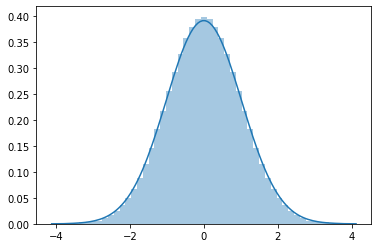

In [58]:
sns.distplot(np_pred_expr_reorder_cleanedup2[0,:])

In [91]:
grm, p = hl.stats.LinearMixedModel.from_kinship(
    y = np_trait[:, 0],
    x = np_covar_with_intercept,
    k = np.dot(np_pred_expr_cleanedup.transpose(), np_pred_expr_cleanedup) / np_pred_expr_cleanedup.shape[0]
)

In [92]:
grm.fit()

In [93]:
grm.h_sq

0.15346540363357017

In [94]:
grm, p = hl.stats.LinearMixedModel.from_random_effects(
    y = np_trait[:, 0],
    x = np_covar_with_intercept,
    z = np_pred_expr_cleanedup.transpose() / np.sqrt(np_pred_expr_cleanedup.shape[0])
)

In [95]:
grm.fit()

In [96]:
grm.h_sq

0.15346515381537873

In [104]:
grm, p = hl.stats.LinearMixedModel.from_random_effects(
    y = np_trait[:, 0],
    x = np_covar_with_intercept,
    z = np_pred_expr_cleanedup2.transpose() / np.sqrt(np_pred_expr_cleanedup2.shape[0])
)


In [105]:
grm.fit()
grm.h_sq

0.1627173305795691